[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/Users/adrianpawlowski/Algorithmic-Trading-Tool-Senior-Design/ML Model/src/data_processing.py:81: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
2024-10-11 14:30:29.490358: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-10-11 14:30:29.490380: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-10-11 14:30:29.490386: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-10-11 14:30:29.490403: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-11 14:30:29.490414: I tensorflow/core/c

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


2024-10-11 14:30:29.709934: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Day 1: Predicted: 222.44332885742188, Actual: 261.6300048828125
Day 2: Predicted: 224.3121795654297, Actual: 258.0199890136719
Day 3: Predicted: 226.97470092773438, Actual: 249.02000427246094
Day 4: Predicted: 230.15769958496094, Actual: 240.66000366210938
Day 5: Predicted: 233.58563232421875, Actual: 250.0800018310547


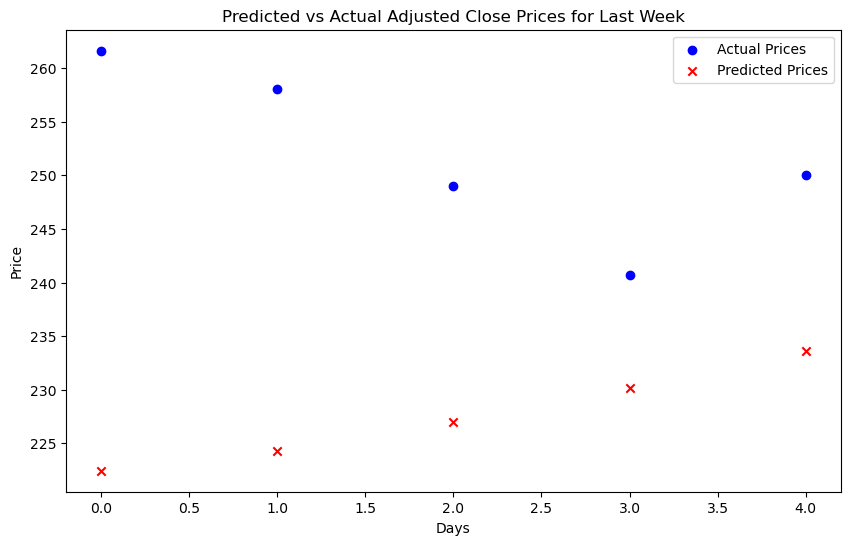

In [1]:
import sys
import os

# Get the absolute path to the `src` directory
src_path = os.path.abspath(os.path.join('..', 'src'))

# Add the `src` directory to the Python path
if src_path not in sys.path:
    sys.path.append(src_path)

import numpy as np
import pandas as pd
from data_processing import fetch_data_up_to_last_week, fetch_last_week_data, preprocess_data, create_lstm_input
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

historical_data = fetch_data_up_to_last_week()

last_week_data = fetch_last_week_data()

preprocessed_historical_data, scaler = preprocess_data(historical_data)

lookback = 20
X_input, _ = create_lstm_input(preprocessed_historical_data, target_column='Adj Close', lookback=lookback)

model = load_model("../models/lstm_tsla_model_rework_v3.h5")

predicted_prices = model.predict(X_input[-5:])

predicted_prices_rescaled = scaler.inverse_transform(predicted_prices)

actual_prices = last_week_data['Adj Close'].values

for i in range(len(actual_prices)):
    print(f"Day {i+1}: Predicted: {predicted_prices_rescaled[i][0]}, Actual: {actual_prices[i]}")

plt.figure(figsize=(10,6))
plt.scatter(range(len(actual_prices)), actual_prices, label='Actual Prices', color='blue', marker='o')
plt.scatter(range(len(predicted_prices_rescaled)), predicted_prices_rescaled, label='Predicted Prices', color='red', marker='x')
plt.title('Predicted vs Actual Adjusted Close Prices for Last Week')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()